# Introduction

This notebook is intended to help decide where to have dinner in San Francisco, safely. The data used for this are:
1. [Foursquare API](https://developer.foursquare.com/docs/api/venues/explore)
2. [SF Police Department Incident Reports: 2018 to Present](https://data.sfgov.org/Public-Safety/Police-Department-Incident-Reports-2018-to-Present/wg3w-h783)

The final product of the notebook is an interactive map of SF, with districts colored by crime rate and markers showing restaurants, as well as sample crimes in the vicinity.

In [324]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library

print('Folium installed')
print('Libraries imported.')

In [342]:
pd.set_option('display.notebook_repr_html', True)

def _repr_latex_(self):
    return "\centering{%s}" % self.to_latex()

pd.DataFrame._repr_latex_ = _repr_latex_  # monkey patch pandas DataFrame

CLIENT_ID = 'R3IASVU5PXYSX2RCMNB3KJTEKMUSRXI0ZKQX1NMBOV1LY4W0' # your Foursquare ID
CLIENT_SECRET = 'RHZYEXWQ5AUX3D1VFFGPR4QXKLZPOEJJZFMPZX5UH0MV32HP' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 3000

In [343]:
#crime_dataset = 'https://data.sfgov.org/resource/wg3w-h783.csv'
crime_dataset = 'https://data.sfgov.org/api/views/wg3w-h783/rows.csv?accessType=DOWNLOAD'
df = pd.read_csv(crime_dataset)

## Crime dataset exploration

The dataset published by the SFPD includes important information regarding the incident (e.g. category) as well as its location. Most of the data in the 34 columns of this dataset (shown in table \ref{tbl:sfpdFull}) will be useless for the purpose of this notebook, so only ``Police District``, ``Latitude``, ``Longitude`` and ``Incident Category`` will be retained, as illustrated in table \ref{tbl:sfpdRelevantCols}.

In [344]:
df.head()

,Incident Datetime,Incident Date,Incident Time,Incident Year,Incident Day of Week,Report Datetime,Row ID,Incident ID,Incident Number,CAD Number,...,Longitude,point,SF Find Neighborhoods,Current Police Districts,Current Supervisor Districts,Analysis Neighborhoods,HSOC Zones as of 2018-06-05,OWED Public Spaces,Central Market/Tenderloin Boundary Polygon - Updated,Parks Alliance CPSI (27+TL sites)
0,2018/12/02 12:45:00 AM,2018/12/02,00:45,2018,Sunday,2018/12/02 01:56:00 AM,74374327130,743743,180908554,183360210.0,...,-122.404795,"(37.78490829943, -122.40479506276)",32.0,5.0,10.0,8.0,NaN,NaN,NaN,NaN
1,2018/12/01 08:30:00 PM,2018/12/01,20:30,2018,Saturday,2018/12/01 09:18:00 PM,74370071000,743700,180908112,183353564.0,...,-122.408036,"(37.786409612811, -122.408036237445)",19.0,6.0,3.0,36.0,NaN,NaN,1.0,NaN
2,2019/03/18 02:01:00 PM,2019/03/18,14:01,2019,Monday,2019/03/18 02:21:00 PM,78164004134,781640,190194129,190772267.0,...,-122.406699,"(37.756833733806, -122.406699002688)",53.0,3.0,2.0,20.0,3.0,NaN,NaN,NaN
3,2019/03/20 08:00:00 AM,2019/03/20,08:00,2019,Wednesday,2019/03/20 02:06:00 PM,78169706244,781697,190199583,190792201.0,...,-122.404865,"(37.78400661242, -122.404864795177)",32.0,1.0,10.0,34.0,NaN,NaN,NaN,NaN
4,2019/03/12 01:30:00 PM,2019/03/12,13:30,2019,Tuesday,2019/03/15 06:02:00 PM,78154706372,781547,196055103,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [345]:
df = df[df['Police District'] !='Out of SF']
df=df[['Police District','Latitude','Longitude','Incident Category']].dropna(thresh=2)
df.head()

,Police District,Latitude,Longitude,Incident Category
0,Southern,37.784908,-122.404795,Other Miscellaneous
1,Central,37.786410,-122.408036,Lost Property
2,Mission,37.756834,-122.406699,Assault
3,Southern,37.784007,-122.404865,Larceny Theft
4,Central,NaN,NaN,Larceny Theft


In [330]:
latlons = df.groupby(['Police District'], as_index=False).apply(lambda df: df.sample(1))

Some of the incidents reported are not relevant or to vague to include in the analysis, so they will be dropped.
Incidents from categories ``Gambling``, ``Liquor Laws``, ``Vehicle Impounded``, ``Vehicle Misplaced``, ``Case Closure``, ``Other``, ``Miscellaneous Investigation``, ``Recovered Vehicle``, ``Non-Criminal``, ``Other Miscellaneous`` amount to 36124 and after filtering the dataset is left with 158729 incidents.
Table \ref{tbl:sfpdIncidentByCategory} shows number of incidents per category, also visualized in figure \ref{fig:barCrimePerCategory}. Figure \ref{fig:barCrimePerDistrict} shows the incident numbers per district and figure \ref{fig:barCrimePerCategoryDistrict} as well as table \ref{tbl:barCrimePerCategoryDistrict} show that information combined.

In [347]:
categories = df.groupby(['Incident Category'], as_index=False).size().sort_values(ascending=True).to_frame(name='Count').reset_index()
#print(categories)

not_interesting=['Gambling', 'Liquor Laws', 'Vehicle Impounded', 'Vehicle Misplaced', 'Case Closure', 'Other', 'Miscellaneous Investigation', 'Recovered Vehicle', 'Non-Criminal', 'Other Miscellaneous']
dfFiltered = df[ ~df['Incident Category'].isin(not_interesting)]
#print('Cleaned ' + str(len(df)-len(dfFiltered)) + ' records, number of incidents left is ' + str(len(dfFiltered)))

categories = dfFiltered.groupby(['Incident Category'], as_index=False).size().sort_values(ascending=True).to_frame(name='Count').reset_index()

df = dfFiltered
print(categories)

                             Incident Category  Count
0       Human Trafficking, Commercial Sex Acts      5
1                              Weapons Offence      6
2                                     Homicide     30
3                                   Suspicious     32
4                         Motor Vehicle Theft?     37
5                                         Rape     56
6                               Drug Violation     61
7                                      Suicide     81
8   Human Trafficking (A), Commercial Sex Acts     85
9                              Courtesy Report    131
10                                 Fire Report    189
11                                   Vandalism    235
12                                Embezzlement    236
13                              Family Offense    255
14                           Juvenile Offenses    263
15                           Traffic Collision    354
16                                 Sex Offense    402
17                          

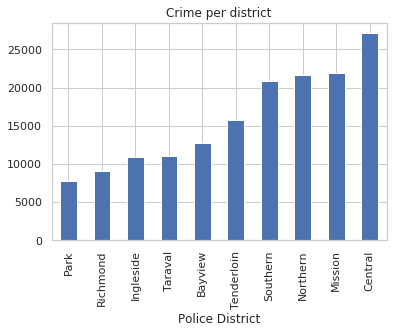

In [352]:
%matplotlib inline
df.groupby(['Police District']).size().sort_values(ascending=True).T.plot(kind='bar', title='Crime per district');


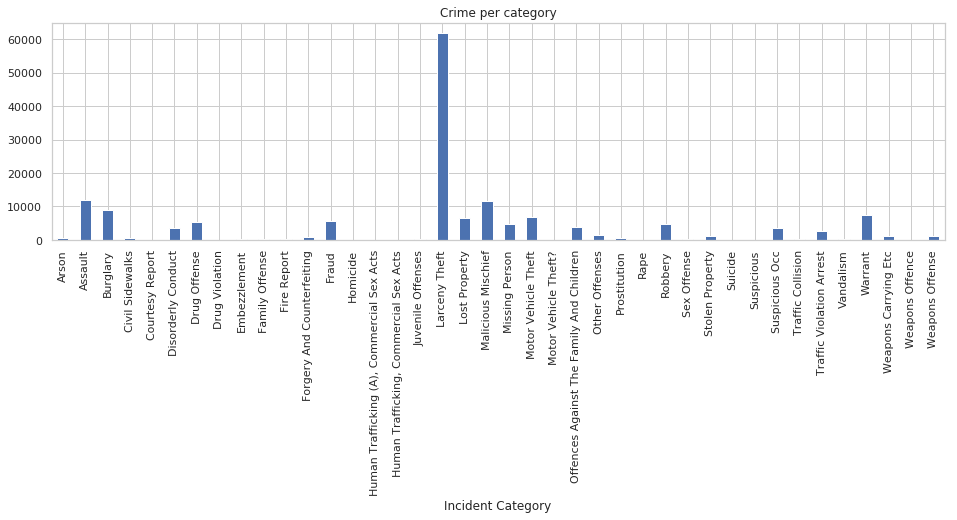

In [353]:
df.groupby(['Incident Category']).size().T.plot(kind='bar', title='Crime per category', figsize=(16,4));

In [341]:
df.groupby(['Incident Category','Police District']).size().sort_values(ascending=False)\
                                    .to_frame(name = 'count').reset_index().head(10)

,Incident Category,Police District,count
0,Larceny Theft,Central,14091
1,Larceny Theft,Northern,11128
2,Larceny Theft,Southern,8234
3,Larceny Theft,Mission,7334
4,Larceny Theft,Richmond,4533
5,Larceny Theft,Taraval,3866
6,Larceny Theft,Tenderloin,3734
7,Larceny Theft,Bayview,3487
8,Larceny Theft,Ingleside,2792
9,Larceny Theft,Park,2703


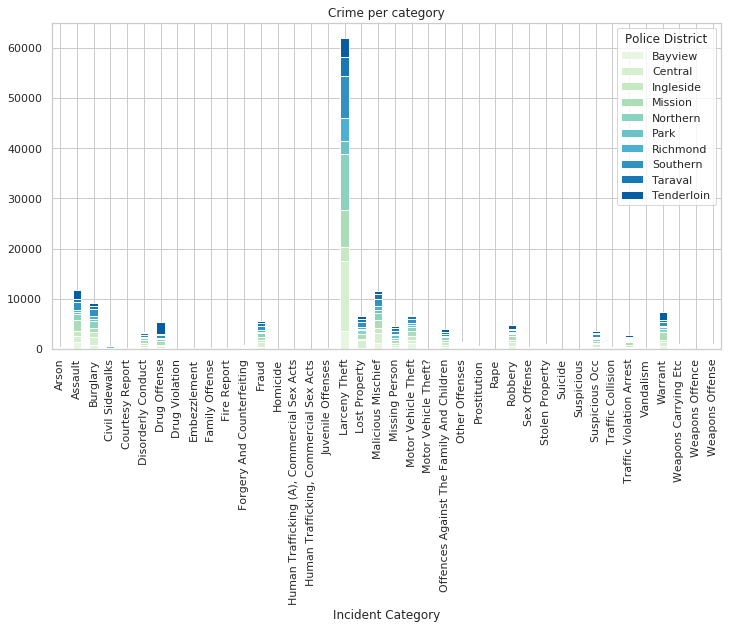

In [354]:
#df.pivot_table(['Incident Category', 'Police District'], columns='Incident Category')
import seaborn as sns
from matplotlib.colors import ListedColormap
sns.set(style="whitegrid")
#sns.set()
df.groupby(['Police District','Incident Category']).size().unstack()\
            .T.plot(kind='bar', stacked=True, title='Crime per category',
                   colormap=ListedColormap(sns.color_palette("GnBu", 10)), 
                    figsize=(12,6));

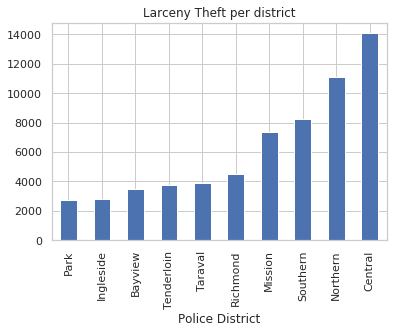

In [355]:
df[df['Incident Category'] == 'Larceny Theft'].groupby('Police District').size().sort_values(ascending=True).plot(kind='bar', title='Larceny Theft per district');

## Crime dataset summary

Most important information regarding crime rate per category and district is shown in table \ref{tbl:pivotCrimeByDistrictCategory}.

In [350]:
dfGrouped = df.groupby(['Incident Category','Police District']).size().sort_values(ascending=False)\
                                    .to_frame(name = 'count').reset_index().fillna(0)
output = dfGrouped.pivot_table(columns='Police District', index='Incident Category', values='count')
output

Police District,Bayview,Central,Ingleside,Mission,Northern,Park,Richmond,Southern,Taraval,Tenderloin
Incident Category,,,,,,,,,,
Arson,73.0,65.0,44.0,60.0,37.0,12.0,24.0,60.0,22.0,56.0
Assault,1311.0,1363.0,944.0,2054.0,1253.0,430.0,363.0,1586.0,694.0,1815.0
Burglary,833.0,1590.0,857.0,910.0,1358.0,491.0,449.0,1407.0,753.0,429.0
Civil Sidewalks,NaN,15.0,NaN,168.0,3.0,437.0,8.0,6.0,NaN,3.0
Courtesy Report,17.0,20.0,11.0,16.0,9.0,6.0,12.0,15.0,12.0,13.0
Disorderly Conduct,375.0,420.0,337.0,608.0,378.0,115.0,161.0,422.0,291.0,323.0
Drug Offense,188.0,375.0,216.0,791.0,347.0,181.0,85.0,664.0,112.0,2402.0
Drug Violation,8.0,3.0,9.0,8.0,2.0,1.0,NaN,8.0,NaN,22.0
Embezzlement,28.0,37.0,10.0,28.0,19.0,7.0,15.0,41.0,16.0,35.0


In [351]:
# This cell shows the same pivot table as above, but colored, it's ignored for the PDF output
output.style.background_gradient(cmap='Oranges', axis=1).set_caption('Incident number by district and category')

Police District,Bayview,Central,Ingleside,Mission,Northern,Park,Richmond,Southern,Taraval,Tenderloin
Incident Category,,,,,,,,,,
Arson,73,65,44,60,37,12,24,60,22,56
Assault,1311,1363,944,2054,1253,430,363,1586,694,1815
Burglary,833,1590,857,910,1358,491,449,1407,753,429
Civil Sidewalks,nan,15,nan,168,3,437,8,6,nan,3
Courtesy Report,17,20,11,16,9,6,12,15,12,13
Disorderly Conduct,375,420,337,608,378,115,161,422,291,323
Drug Offense,188,375,216,791,347,181,85,664,112,2402
Drug Violation,8,3,9,8,2,1,nan,8,nan,22
Embezzlement,28,37,10,28,19,7,15,41,16,35


# Venues dataset exploration

For each of the districts in the SFPD dataset a single incident was randomly selected in order to get its latitude and longitude, which the serve to query the Foursquare API. Again the full dataset consist 31 columns, of which only several (``['venue.location.lat','venue.location.lng','venue.name']``) will be useful for the purpose of this analysis, other columns will be dropped, as well as locations with NaN coordinates. At the time of writing of this report - the venue dataset consisted of 884 restaurants.

In [394]:
geolocator = Nominatim(user_agent="foursquare_agent")

allvenues = pd.DataFrame()
CLIENT_ID='TRJOWYF3BNYWWSKY4YOT45SYSW1IV4S332PWWW3VCSCHN3DH'
CLIENT_SECRET='EY1TCOVDT0A4JCX0QP41COTMQEHLHBWMMJ0RDNZWZKMOVKVX'
for idx,row in latlons.iterrows():
    
    latitude = row['Latitude']
    longitude = row['Longitude']
    limit = 50
    radius = 1000
    url = 'https://api.foursquare.com/v2/search/recommendations?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}&intent=food'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius, LIMIT)
    results = requests.get(url).json()
#    venues = results['response']['groups']
    # tranform venues into a dataframe
    dataframe = json_normalize(results['response']['group']['results'])

    dataframe['Police District'] = row['Police District']
    allvenues = pd.concat([allvenues,dataframe], sort=True)
    
allvenues = allvenues[['Police District','venue.location.lat','venue.location.lng','venue.name','venue.id']].dropna()

In [395]:
import time

ratings = []
for idx,row in allvenues.iterrows():
    url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v=20190504'.format(row['venue.id'],CLIENT_ID, CLIENT_SECRET)
    results = requests.get(url).json()

    if 'venue' in results['response'] and 'rating' in results['response']['venue']:
        ratings.append(results['response']['venue']['rating'])
    else: 
        #print(url)
        #print(results['response'])
        ratings.append(float('nan'))
    time.sleep(0.1)


In [397]:
print(len(ratings))

777


In [398]:
allvenues['rating'] = ratings

In [406]:
venuesNoNans = allvenues.dropna()
print(len(venuesNoNans))
venuesNoNans.head()

478


,Police District,venue.location.lat,venue.location.lng,venue.name,venue.id,rating
0,Bayview,37.734826,-122.390764,Radio Africa & Kitchen,4f56b36a6b7406c0ea010e9b,8.4
1,Bayview,37.736240,-122.390361,TATO,5b89f7f6a0215b002c7cfd73,8.4
2,Bayview,37.726908,-122.391536,Craftsman and Wolves Den,5703cab0498e52dae7c36bcf,8.2
3,Bayview,37.732747,-122.392245,Fox and Lion Bakery,5618351f498e69559d3990b7,7.8
4,Bayview,37.734287,-122.390462,Old Skool Cafe,4d0401f454d0236aa38cecd5,7.4


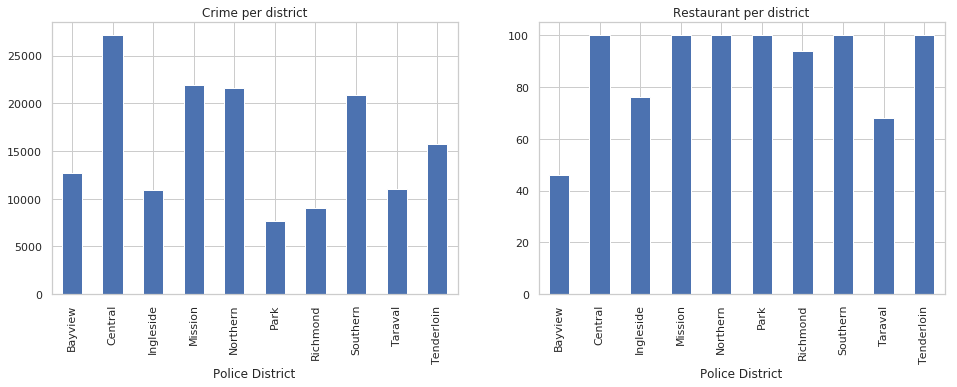

In [364]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,5))
df.groupby(['Police District']).size().T.plot(kind='bar',ax=axes[0], title='Crime per district')
allVenues.groupby('Police District').size().T.plot(kind='bar', ax=axes[1], title='Restaurant per district');

In [463]:
# create map and display it
sanfran_map = folium.Map(location=[latitude, longitude], zoom_start=12)

# display the map of San Francisco
sanfran_map

In [223]:
# download districts geojson file
!wget --quiet "https://data.sfgov.org/api/geospatial/wkhw-cjsf?method=export&format=GeoJSON" -O sf_pd_districts.json
    
print('GeoJSON file downloaded!')

GeoJSON file downloaded!


In [301]:
sf_geo = r'sf_pd_districts.json' # geojson file

# create a plain world map


In [407]:
from folium.plugins import FastMarkerCluster
sf_map = folium.Map(location=[latitude, longitude], zoom_start=12)
dfGrouped = df.groupby(['Police District']).size().sort_values(ascending=False)\
                                    .to_frame(name = 'count').reset_index()
# create a numpy array of length 6 and has linear spacing from the minium total immigration to the maximum total immigration
threshold_scale = np.linspace(dfGrouped['count'].min(),
                              dfGrouped['count'].max(),
                              6, dtype=int)
threshold_scale = threshold_scale.tolist() # change the numpy array to a list
threshold_scale[-1] = threshold_scale[-1] + 1 # make sure that the last value of the list is greater than the maximum immigration
dfGrouped['Police District Up'] = dfGrouped['Police District'].str.upper()
# generate choropleth map using the total immigration of each country to Canada from 1980 to 2013
sf_map.choropleth(
    geo_data=sf_geo,
    data=dfGrouped,
    columns=['Police District Up', 'count'],
    key_on='feature.properties.district',
    threshold_scale=threshold_scale,
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Number of incidents',
    reset=True
)
venues100 = allvenues.iloc[0:100,:]#len(allvenues), :]
venues100 = venuesNoNans
venues100 = venues100[['venue.location.lat','venue.location.lng','venue.name', 'rating']].dropna()

icon_create_function = """\
function(cluster) {
    return L.divIcon({
    html: '<b>Venues: ' + cluster.getChildCount() + '</b>',
    className: 'marker-cluster marker-cluster-large',
    iconSize: new L.Point(20, 20)
    });
}"""

# instantiate a mark cluster object for the incidents in the dataframe
venues = plugins.MarkerCluster(icon_create_function=icon_create_function).add_to(sf_map)
#allvenues = allvenues.dropna()
# loop through the dataframe and add each data point to the mark cluster
for lat, lng, label, in zip(venues100['venue.location.lat'], venues100['venue.location.lng'], venues100['venue.name']):
    #print('adding ' + str(lat) + ',' + str(lng) + ', ' + label)
    label=label.replace("'", "").replace('"',"")
    folium.Marker(
        location=[lat, lng],
        icon=None,
        popup=label,
    ).add_to(venues)
    #break
icon_create_function2 = """\
function(cluster) {
    return L.divIcon({
    html: '<b>Crimes: ' + cluster.getChildCount() + '</b>',
    className: 'marker-cluster marker-cluster-large',
    iconSize: new L.Point(20, 20)
    });
}"""  
incidents = plugins.MarkerCluster(icon_create_function=icon_create_function2).add_to(sf_map)
#allvenues = allvenues.dropna()
# loop through the dataframe and add each data point to the mark cluster
selIncs = df[['Latitude','Longitude','Incident Category']].sample(1000).dropna()


for lat, lng, label, in zip(selIncs['Latitude'], selIncs['Longitude'], selIncs['Incident Category']):
    #print('adding ' + str(lat) + ',' + str(lng) + ', ' + label)
    label=label.replace("'", "").replace('"',"")
    folium.Marker(
        location=[lat, lng],
        icon=None,#folium.Icon(color='red'),# icon='info-sign'),
        popup=label,
    ).add_to(incidents)
    #break
# display map
sf_map

## Explore highest rated restaurants by district

As the first step to choose the best place to dine we will look into how ratings per district are distributed.


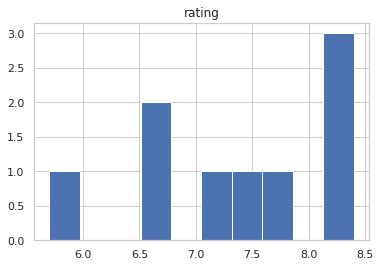

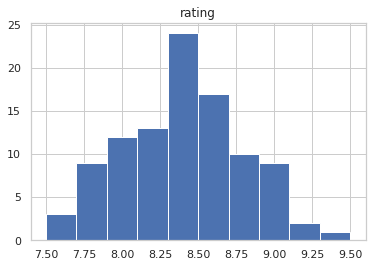

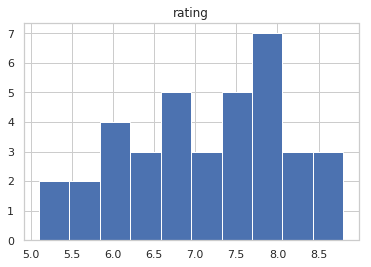

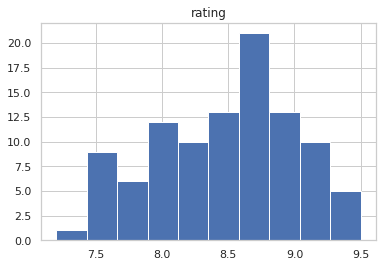

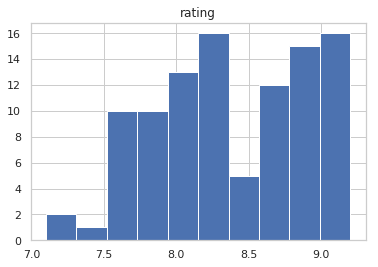

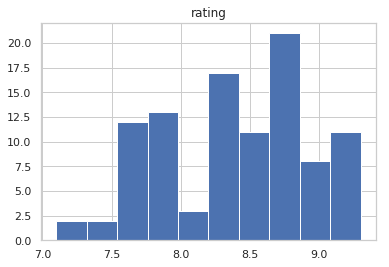

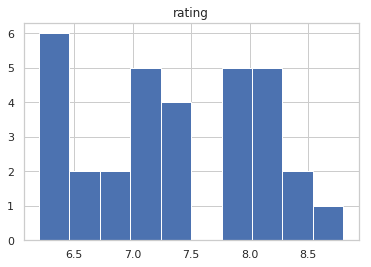

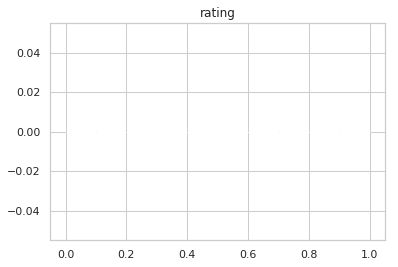

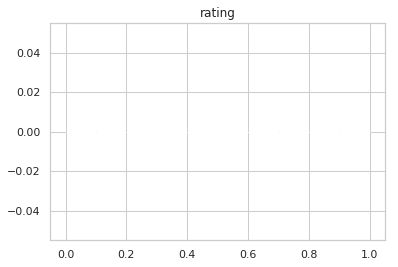

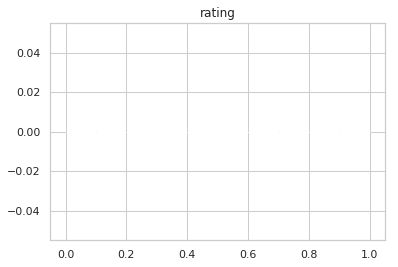

In [415]:
for district in latlons['Police District'].values:
    venuesInDistrict = venuesNoNans[venuesNoNans['Police District'] == district]
    venuesInDistrict.hist(bins=10, column='rating');

In [458]:
bins = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
groupedVenues = venuesNoNans.groupby(['Police District', pd.cut(venuesNoNans.rating, bins)]).size()
groupedVenues = groupedVenues.fillna(0)
#venuesInDistrict.pivot_table(columns='Police District', index='Incident Category', values='count')
#print(groupedVenues.fillna(0))
groupedVenues = groupedVenues.to_frame(name='count')
output = groupedVenues.pivot_table(columns='Police District', index='rating', values='count', fill_value=0)
#groupedVenues.size().unstack().pivot_table(column=)
output

Police District,Bayview,Central,Ingleside,Mission,Northern,Park,Richmond
rating,,,,,,,
"(5, 6]",1,0,4,0,0,0,0
"(6, 7]",2,0,13,0,0,0,12
"(7, 8]",3,24,14,24,28,31,12
"(8, 9]",3,73,6,61,63,58,8
"(9, 10]",0,3,0,15,9,11,0


In [462]:
output.style.background_gradient(cmap='Greens', axis=1).set_caption('Venues rating by district')

Police District,Bayview,Central,Ingleside,Mission,Northern,Park,Richmond
rating,,,,,,,
"(5, 6]",1,0,4,0,0,0,0
"(6, 7]",2,0,13,0,0,0,12
"(7, 8]",3,24,14,24,28,31,12
"(8, 9]",3,73,6,61,63,58,8
"(9, 10]",0,3,0,15,9,11,0


Based on table \ref{tbl:pivotRatingByDistrict} - the districts that have the highest rated venues are Central and Mission, however these are also heavily influenced by crime, as shown in figure \ref{fig:barCrimePerDistrict}. We need to select the neighborhood with best food and relatively low crime. Northern district is 2nd in terms of number of highly rated venues and 3rd in crime rate, however Park district has lowest crime yet pretty decent food, as well.

# Conclusions

Based on analysis of the crime data and venue information provided via Foursquare API we were able to determine that the Park district is the safest (disregarding the kind of incidents, only looking at the volume) while having relatively decent restaurants.